# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   341988.000000  341988.000000  341988.000000  341988.000000   
mean      3223.797936     282.704303       0.086439       0.000249   
std       1943.974204      12.922822       0.321004       0.000466   
min         41.627638     250.083873       0.000008       0.000000   
25%       1152.987320     270.511312       0.000130       0.000002   
50%       3608.409516     285.328962       0.000575       0.000006   
75%       5010.047921     293.711888       0.037928       0.000324   
max       7076.619110     305.881726      12.279954       0.004205   

          clouds_all  
count  341988.000000  
mean       39.871618  
std        39.339560  
min         0.016394  
25%         4.172619  
50%        15.465574  
75%        87.893841  
max        97.951007  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.09794595228508114
Training Loss: 0.08220070639625192
Training Loss: 0.07439270252361893
Validation Loss: 0.06824103826552294
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0711292584054172
Training Loss: 0.06912283087149262
Training Loss: 0.06524153504520655
Validation Loss: 0.05820382365517402
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06171852709725499
Training Loss: 0.05945977399125695
Training Loss: 0.05554766871035099
Validation Loss: 0.04813342828178004
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.051490717455744746
Training Loss: 0.04888175987638533
Training Loss: 0.04466495061293244
Validation Loss: 0.03716746181919334
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03958229892887175
Training Loss: 0.03686512083746493
Training Loss

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:22<30:22, 202.47s/it]

Epoch: 1
Training Loss: 0.3924240057915449
Training Loss: 0.2661916786432266
Training Loss: 0.1545549014955759
Validation Loss: 0.07505759366610076
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07721661474555731
Training Loss: 0.06690869936719537
Training Loss: 0.06269779244437813
Validation Loss: 0.05844125540906124
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06128612400963902
Training Loss: 0.06001778831705451
Training Loss: 0.05776449548080564
Validation Loss: 0.05403635512744443
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05613814000040293
Training Loss: 0.05471042349003255
Training Loss: 0.052287167320027944
Validation Loss: 0.04846372576744369
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05011233407072723
Training Loss: 0.04847588961943984
Training Loss: 

 20%|██        | 2/10 [06:49<27:22, 205.29s/it]

Epoch: 1
Training Loss: 0.11534608302637935
Training Loss: 0.09179124856367707
Training Loss: 0.07371297484263778
Validation Loss: 0.05997425836793492
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06058611212298274
Training Loss: 0.056717491671442986
Training Loss: 0.05197111060842872
Validation Loss: 0.04572328380989225
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04652566473931074
Training Loss: 0.042940226113423706
Training Loss: 0.03818353978917002
Validation Loss: 0.03188419925948877
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03206536617130041
Training Loss: 0.029051096588373185
Training Loss: 0.025766379702836274
Validation Loss: 0.021235056943521742
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.021746720089577138
Training Loss: 0.020575718455947935
Traini

 30%|███       | 3/10 [10:12<23:50, 204.31s/it]

Training Loss: 0.0069128592195920645
Validation Loss: 0.0038976889428044303
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07101884081959725
Training Loss: 0.0688903123140335
Training Loss: 0.06480706416070461
Validation Loss: 0.059545787532677814
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06082166353240609
Training Loss: 0.057326539661735294
Training Loss: 0.05218531360849738
Validation Loss: 0.04577188172869468
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04565915473736823
Training Loss: 0.04114270638674498
Training Loss: 0.03624433615244925
Validation Loss: 0.030678111662188274
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03025416542775929
Training Loss: 0.027467521601356567
Training Loss: 0.024889888842590153
Validation Loss: 0.02136307836541634
Validation A

 40%|████      | 4/10 [13:37<20:26, 204.35s/it]

Training Loss: 0.005137191436369903
Validation Loss: 0.0024613735548565897
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.19407282665371894
Training Loss: 0.15259608168154956
Training Loss: 0.11627438463270665
Validation Loss: 0.09022866863380657
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08035013422369958
Training Loss: 0.06922677526250481
Training Loss: 0.06159989908337593
Validation Loss: 0.057135630398988724
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05769574292935431
Training Loss: 0.05577049298211932
Training Loss: 0.052006181739270685
Validation Loss: 0.04786429759324266
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04797728596255183
Training Loss: 0.045287901721894744
Training Loss: 0.04104830056428909
Validation Loss: 0.036244918916667444
Validation Ac

 50%|█████     | 5/10 [17:01<17:01, 204.32s/it]

Training Loss: 0.005857552752713673
Validation Loss: 0.003033525455648896
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11116665113717318
Training Loss: 0.0879884497076273
Training Loss: 0.07588159443810583
Validation Loss: 0.06922508119029945
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07100687514990568
Training Loss: 0.06912689685821533
Training Loss: 0.06505087291821837
Validation Loss: 0.06050385551506214
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061446578353643415
Training Loss: 0.05913521159440279
Training Loss: 0.05471732260659337
Validation Loss: 0.0499628951793976
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049911941913887856
Training Loss: 0.04712654992006719
Training Loss: 0.04263886742293835
Validation Loss: 0.03811781338593933
Validation Accurac

 60%|██████    | 6/10 [20:26<13:37, 204.40s/it]

Epoch: 1
Training Loss: 0.5689039728045464
Training Loss: 0.4585856153070927
Training Loss: 0.35605837874114515
Validation Loss: 0.2544459392515461
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.20690063513815404
Training Loss: 0.1348988175019622
Training Loss: 0.08771699141710997
Validation Loss: 0.05959908986526929
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.062282237764447926
Training Loss: 0.0587742999009788
Training Loss: 0.05642272185534239
Validation Loss: 0.049971286040008736
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054838852435350416
Training Loss: 0.05332090183161199
Training Loss: 0.051285623656585816
Validation Loss: 0.04556732572447718
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04930577360093594
Training Loss: 0.04761679667048156
Training Loss:

 70%|███████   | 7/10 [23:50<10:13, 204.42s/it]

Validation Loss: 0.002876648810179381
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3463323404639959
Training Loss: 0.273116496950388
Training Loss: 0.2027866702899337
Validation Loss: 0.13599266296022394
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11778440058231354
Training Loss: 0.08873642690479755
Training Loss: 0.07530136561021208
Validation Loss: 0.0680161231103238
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07130297398194671
Training Loss: 0.06925543991848826
Training Loss: 0.06557966098189354
Validation Loss: 0.05984924750381641
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06264953238889576
Training Loss: 0.06031691957265139
Training Loss: 0.05660234738141298
Validation Loss: 0.0505852507155263
Validation Accuracy: 0.0
***********************************

 80%|████████  | 8/10 [27:15<06:48, 204.46s/it]

Training Loss: 0.00577643547905609
Validation Loss: 0.0030963041118524048
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.35448402032256127
Training Loss: 0.27975185759365556
Training Loss: 0.19554028429090978
Validation Loss: 0.12428057846728335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10178298154845834
Training Loss: 0.0778717951849103
Training Loss: 0.06723069017753006
Validation Loss: 0.0609524016885945
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06403129141777754
Training Loss: 0.06291512932628393
Training Loss: 0.060233597420156
Validation Loss: 0.055768616162659074
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05819935714825988
Training Loss: 0.056673921588808296
Training Loss: 0.053602461656555536
Validation Loss: 0.049239813276890955
Validation Accurac

 90%|█████████ | 9/10 [30:40<03:24, 204.68s/it]

Validation Loss: 0.0035346971557925592
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4217975753545761
Training Loss: 0.2951085493713617
Training Loss: 0.1735702247917652
Validation Loss: 0.08108438262611292
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08420499233528972
Training Loss: 0.07162864351645112
Training Loss: 0.0660504749789834
Validation Loss: 0.06080132463340009
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06267413788475096
Training Loss: 0.059815908055752515
Training Loss: 0.05587253663688898
Validation Loss: 0.050876738712861296
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05172864178195596
Training Loss: 0.04866652335040271
Training Loss: 0.044723129579797384
Validation Loss: 0.03972822614014149
Validation Accuracy: 0.0
*****************************

100%|██████████| 10/10 [34:05<00:00, 204.79s/it]

Training Loss: 0.005613699913956225
Validation Loss: 0.0027293910290731977
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 200
**************************************************


100%|██████████| 10/10 [34:05<00:00, 204.53s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.21615898955613375
Training Loss: 0.15265004113316535
Training Loss: 0.10621521228924394
Validation Loss: 0.0830639253548357
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07879519971087574
Training Loss: 0.0729290952719748
Training Loss: 0.06952181966975331
Validation Loss: 0.06886630697866504
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06639449765905737
Training Loss: 0.0626447119563818
Training Loss: 0.05913176404312253
Validation Loss: 0.057876281649544
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05566394468769431
Training Loss: 0.05208588032051921
Training Loss: 0.04849411942064762
Validation Loss: 0.04664696616989173
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04475317597389221
Training Loss: 0.041503610545769336
Training Loss: 0.

 10%|█         | 1/10 [03:29<31:27, 209.67s/it]

Validation Loss: 0.0036094561029549983
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.38695797957479955
Training Loss: 0.2455334684252739
Training Loss: 0.15590291373431683
Validation Loss: 0.10583104779211323
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09246638245880603
Training Loss: 0.07615673383697867
Training Loss: 0.07091523848474025
Validation Loss: 0.06959462410697106
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06815537812188267
Training Loss: 0.06388691939413547
Training Loss: 0.06056164927780628
Validation Loss: 0.05924879060534949
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05774961898103356
Training Loss: 0.05382747393101454
Training Loss: 0.0502343600615859
Validation Loss: 0.047953588762477545
Validation Accuracy: 0.0
*****************************

 20%|██        | 2/10 [07:01<28:05, 210.75s/it]

Validation Loss: 0.004573639533273206
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4981366804242134
Training Loss: 0.36243709847331046
Training Loss: 0.25672820903360843
Validation Loss: 0.17377017224940022
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1466884559765458
Training Loss: 0.100570127107203
Training Loss: 0.07915496669709682
Validation Loss: 0.07163134822098727
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07016345197334886
Training Loss: 0.06542200140655041
Training Loss: 0.06285397201776505
Validation Loss: 0.06283839026026511
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06208292793482542
Training Loss: 0.05857958324253559
Training Loss: 0.05529912680387497
Validation Loss: 0.054182784778348515
Validation Accuracy: 0.0
********************************

 30%|███       | 3/10 [10:32<24:35, 210.85s/it]

Validation Loss: 0.0032740596131149552
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10780364185571671
Training Loss: 0.08662257371470332
Training Loss: 0.07605580465868116
Validation Loss: 0.07409862259381943
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07262533966451884
Training Loss: 0.06946686130017042
Training Loss: 0.06733001885935665
Validation Loss: 0.06751279926367021
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06622882302850484
Training Loss: 0.06289291447028518
Training Loss: 0.059602493140846494
Validation Loss: 0.057939203790901755
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05600063914433122
Training Loss: 0.05150687778368592
Training Loss: 0.04676518656313419
Validation Loss: 0.043024809696198846
Validation Accuracy: 0.0
*************************

 40%|████      | 4/10 [14:03<21:05, 210.86s/it]

Validation Loss: 0.0035658310680242067
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1316428603604436
Training Loss: 0.08897119663655757
Training Loss: 0.06903907969594002
Validation Loss: 0.06303098287140385
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.061679734252393245
Training Loss: 0.05758777920156717
Training Loss: 0.05431519165635109
Validation Loss: 0.05208091822902808
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051013657543808225
Training Loss: 0.04678556893952191
Training Loss: 0.042646890431642534
Validation Loss: 0.039606678550749015
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.038572120340541007
Training Loss: 0.035423809746280316
Training Loss: 0.0323574058432132
Validation Loss: 0.03007493292117554
Validation Accuracy: 0.0
************************

 50%|█████     | 5/10 [17:37<17:41, 212.22s/it]

Validation Loss: 0.003227270314250183
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14015007369220256
Training Loss: 0.09361100787296892
Training Loss: 0.07222849801182747
Validation Loss: 0.06638267242841506
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06451766857877374
Training Loss: 0.060340334959328175
Training Loss: 0.05719191905111074
Validation Loss: 0.05643109213351534
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.055231237281113864
Training Loss: 0.051524426620453596
Training Loss: 0.04774659783579409
Validation Loss: 0.04614524939882286
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04463033217936754
Training Loss: 0.040925252437591556
Training Loss: 0.03694759827107191
Validation Loss: 0.034909773387768295
Validation Accuracy: 0.0
************************

 60%|██████    | 6/10 [21:09<14:07, 211.96s/it]

Validation Loss: 0.003055394283794076
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3154377184808254
Training Loss: 0.22602857381105423
Training Loss: 0.1600764000043273
Validation Loss: 0.11588832246286146
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10139544792473316
Training Loss: 0.0789284286275506
Training Loss: 0.0704538681358099
Validation Loss: 0.06841374475383356
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06703143680468202
Training Loss: 0.06263995461165905
Training Loss: 0.059366267174482346
Validation Loss: 0.058068182863546224
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05686744850128889
Training Loss: 0.05304449547082186
Training Loss: 0.04958976376801729
Validation Loss: 0.047387050422892145
Validation Accuracy: 0.0
******************************

 70%|███████   | 7/10 [24:40<10:35, 211.77s/it]

Validation Loss: 0.004138750486531075
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5407610665261745
Training Loss: 0.4278099963068962
Training Loss: 0.32571463845670223
Validation Loss: 0.22393890763266702
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.18620574809610843
Training Loss: 0.11450941827148199
Training Loss: 0.07724663181230426
Validation Loss: 0.06077588349580765
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05732748629525304
Training Loss: 0.05110749879851937
Training Loss: 0.04735789728350937
Validation Loss: 0.04570548090916336
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04386264493688941
Training Loss: 0.0401079704426229
Training Loss: 0.03598823343403637
Validation Loss: 0.033142473098685905
Validation Accuracy: 0.0
*******************************

 80%|████████  | 8/10 [28:11<07:03, 211.59s/it]

Validation Loss: 0.0041209211497138555
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1726290398463607
Training Loss: 0.11837873619049788
Training Loss: 0.09082749921828509
Validation Loss: 0.0788091112430511
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07496148776262998
Training Loss: 0.06788017811253667
Training Loss: 0.06477533044293522
Validation Loss: 0.06437105999401446
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06338790260255336
Training Loss: 0.05971761748194695
Training Loss: 0.05661120368167758
Validation Loss: 0.055399472458978714
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05405971623957157
Training Loss: 0.050055656153708696
Training Loss: 0.04619928490370512
Validation Loss: 0.043911245494578664
Validation Accuracy: 0.0
***************************

 90%|█████████ | 9/10 [31:43<03:31, 211.70s/it]

Validation Loss: 0.003582094267554832
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4128956939280033
Training Loss: 0.29970432914793493
Training Loss: 0.20050103977322578
Validation Loss: 0.11889689704507925
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09392137508839368
Training Loss: 0.0656758377328515
Training Loss: 0.058959817085415124
Validation Loss: 0.05870412216846193
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05671868681907654
Training Loss: 0.053541976977139714
Training Loss: 0.04989966565743089
Validation Loss: 0.04895781709948618
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0467454643920064
Training Loss: 0.04338504469022155
Training Loss: 0.03941396465525031
Validation Loss: 0.037805571273136676
Validation Accuracy: 0.0
*****************************

100%|██████████| 10/10 [35:15<00:00, 211.54s/it]


Validation Loss: 0.0035664242204393815
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.1267973241209984
Training Loss: 0.0880199852399528
Training Loss: 0.06623166838660836
Validation Loss: 0.05396169865264573
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04969401543028653
Training Loss: 0.04216252620331943
Training Loss: 0.03799825120717287
Validation Loss: 0.035035984705113835
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03213908663019538
Training Loss: 0.026570125478319825
Training Loss: 0.023253486133180557
Validation Loss: 0.020785227548018845
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.018664493816904725
Training Loss: 0.015373661669436843
Training Loss: 0.01374131445772946
Validation Loss: 0.012645302542001425
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.01147691655671224
Training Loss: 0.010058772533666343
Trainin

 10%|█         | 1/10 [03:31<31:42, 211.40s/it]

Validation Loss: 0.0014245289232511615
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3491188833862543
Training Loss: 0.23983360186219216
Training Loss: 0.14792203821241856
Validation Loss: 0.0832121886479455
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06904323631897569
Training Loss: 0.05277738742530346
Training Loss: 0.049271705923601986
Validation Loss: 0.04744830679710351
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04567385843023658
Training Loss: 0.04095318799838424
Training Loss: 0.03868229706771672
Validation Loss: 0.03694316292150394
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03492363005876541
Training Loss: 0.030516040665097534
Training Loss: 0.02813279707916081
Validation Loss: 0.026458948871443393
Validation Accuracy: 0.0
***************************

 20%|██        | 2/10 [07:04<28:20, 212.52s/it]

Validation Loss: 0.0014354193693855465
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09120674410834909
Training Loss: 0.07451297339051961
Training Loss: 0.06698922613635659
Validation Loss: 0.06251446103583501
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059826547652482985
Training Loss: 0.05229880263097584
Training Loss: 0.04535208633169532
Validation Loss: 0.038748098932747735
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.034705048352479936
Training Loss: 0.02730976472143084
Training Loss: 0.021866043712943792
Validation Loss: 0.01901813942741332
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.017203289590543135
Training Loss: 0.014893713513156399
Training Loss: 0.013124857228249312
Validation Loss: 0.012451814760729754
Validation Accuracy: 0.0
********************

 30%|███       | 3/10 [10:37<24:49, 212.72s/it]

Validation Loss: 0.001407853667507229
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10401323394849897
Training Loss: 0.08306475173681975
Training Loss: 0.07458137409761548
Validation Loss: 0.07046329425699883
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0691286296211183
Training Loss: 0.06477248223498464
Training Loss: 0.06103039538487792
Validation Loss: 0.057566997100854056
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.055281934067606925
Training Loss: 0.04925845249556005
Training Loss: 0.04265445892699063
Validation Loss: 0.036975388867811786
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03379796291701496
Training Loss: 0.028513240781612693
Training Loss: 0.023547881385311484
Validation Loss: 0.02068602330150218
Validation Accuracy: 0.0
*************************

 40%|████      | 4/10 [14:10<21:17, 212.94s/it]

Validation Loss: 0.0013459887846266362
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5192641305923462
Training Loss: 0.4001468127965927
Training Loss: 0.2926509939879179
Validation Loss: 0.18328553646303422
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14386703725904226
Training Loss: 0.08843081330880523
Training Loss: 0.06843890124931931
Validation Loss: 0.05758179074892119
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05390109523199499
Training Loss: 0.047370380507782105
Training Loss: 0.04364173193462193
Validation Loss: 0.041929835994733114
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03973898858763278
Training Loss: 0.03554756006225943
Training Loss: 0.032251305030658844
Validation Loss: 0.03038102416477723
Validation Accuracy: 0.0
****************************

 50%|█████     | 5/10 [17:43<17:44, 212.92s/it]

Validation Loss: 0.0012137750463655176
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5217276982963085
Training Loss: 0.42013931676745414
Training Loss: 0.32195357240736483
Validation Loss: 0.21370383252145192
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17181283831596375
Training Loss: 0.11157846163958311
Training Loss: 0.09335138412192463
Validation Loss: 0.08562918708727346
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08352221608161926
Training Loss: 0.07615675441920758
Training Loss: 0.07260011015459895
Validation Loss: 0.06911492435126332
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06748412074521185
Training Loss: 0.06161027871072292
Training Loss: 0.058032955806702376
Validation Loss: 0.05450880375571091
Validation Accuracy: 0.0
****************************

 60%|██████    | 6/10 [21:17<14:12, 213.03s/it]

Validation Loss: 0.0014301150327993234
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3068971396237612
Training Loss: 0.1946584940329194
Training Loss: 0.1164885626360774
Validation Loss: 0.07953171885712852
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07379113700240851
Training Loss: 0.06521546259522439
Training Loss: 0.0630286918208003
Validation Loss: 0.06181685347630325
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0607968074362725
Training Loss: 0.056075970316305755
Training Loss: 0.05273627482354641
Validation Loss: 0.04919495764474629
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.046619241423904896
Training Loss: 0.039962413161993025
Training Loss: 0.03510904542170465
Validation Loss: 0.031092024174149475
Validation Accuracy: 0.0
*****************************

 70%|███████   | 7/10 [24:50<10:39, 213.01s/it]

Validation Loss: 0.0015029244432349393
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.41881006747484206
Training Loss: 0.31972194522619246
Training Loss: 0.21545743450522423
Validation Loss: 0.13084631725396523
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1093304910697043
Training Loss: 0.08051308007910847
Training Loss: 0.07180261123925448
Validation Loss: 0.06626989713261247
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06412537822499871
Training Loss: 0.057404948864132166
Training Loss: 0.05330662304535508
Validation Loss: 0.049133938971344986
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04687053426168859
Training Loss: 0.0407892703730613
Training Loss: 0.036591556873172525
Validation Loss: 0.03289523953832062
Validation Accuracy: 0.0
***************************

 80%|████████  | 8/10 [28:23<07:06, 213.02s/it]

Validation Loss: 0.001412780560255857
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08980071237310767
Training Loss: 0.07016875326633454
Training Loss: 0.05939932806417346
Validation Loss: 0.053414351010289275
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.050658864565193654
Training Loss: 0.043923884499818086
Training Loss: 0.03826276238076389
Validation Loss: 0.03398392781323894
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.030819967170245946
Training Loss: 0.02496006550267339
Training Loss: 0.020678746814373882
Validation Loss: 0.018299813569632655
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.016423717045690865
Training Loss: 0.013992458356078714
Training Loss: 0.012271341518498957
Validation Loss: 0.011775983954056598
Validation Accuracy: 0.0
*******************

 90%|█████████ | 9/10 [31:56<03:33, 213.16s/it]

Validation Loss: 0.0013834326225593062
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12089543366804718
Training Loss: 0.09634256957098841
Training Loss: 0.08320559589192271
Validation Loss: 0.07610640710209335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07410169728100299
Training Loss: 0.06826823187991976
Training Loss: 0.06436639415100216
Validation Loss: 0.06078983152378871
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0582399389706552
Training Loss: 0.05112086908891797
Training Loss: 0.044191290969029066
Validation Loss: 0.038420383043212596
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0350011071562767
Training Loss: 0.029206135054118933
Training Loss: 0.024426869042217733
Validation Loss: 0.02195785755510104
Validation Accuracy: 0.0
**************************

100%|██████████| 10/10 [35:29<00:00, 212.93s/it]


Validation Loss: 0.0014237850559283536
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.13096243403851987
Training Loss: 0.09980234321206809
Training Loss: 0.0834659911878407
Training Loss: 0.07976101143285633
Training Loss: 0.07611587516963482
Training Loss: 0.07301185784861446
Training Loss: 0.07166178153827786
Validation Loss: 0.06976742762025823
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06968913070857524
Training Loss: 0.06842622781172394
Training Loss: 0.06475364733487368
Training Loss: 0.06344629047438502
Training Loss: 0.05933924656361342
Training Loss: 0.0552347225509584
Training Loss: 0.052547162808477876
Validation Loss: 0.05028354449804579
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04988155825994909
Training Loss: 0.04713211896829307
Training Loss: 0.04237565565854311
Training Loss: 0.038072468126192686
Training Loss: 0.030589609649032356
Training Loss: 0.02457016933709383
Training Loss: 0.02034470540937036
Validation 

 10%|█         | 1/10 [06:49<1:01:26, 409.67s/it]

Training Loss: 0.001809842199436389
Validation Loss: 0.002673557733206518
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14903798945248126
Training Loss: 0.10311982883140444
Training Loss: 0.0733369055390358
Training Loss: 0.0650761417672038
Training Loss: 0.05992023212835193
Training Loss: 0.055771875232458114
Training Loss: 0.053656765930354594
Validation Loss: 0.05293956795212035
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05321367517113686
Training Loss: 0.0504659715667367
Training Loss: 0.046074338676407936
Training Loss: 0.0415238933917135
Training Loss: 0.03194939043372869
Training Loss: 0.02621725500561297
Training Loss: 0.022745458311401307
Validation Loss: 0.026329003661619815
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0337961392197758
Training Loss: 0.03156375304795802
Training Loss: 0.029175658817403017
T

 20%|██        | 2/10 [13:38<54:32, 409.03s/it]  

Training Loss: 0.0019437806950008962
Validation Loss: 0.0028772339150039236
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7032337385416031
Training Loss: 0.5679137778282165
Training Loss: 0.4428128425776958
Training Loss: 0.34094569079577924
Training Loss: 0.24745286554098128
Training Loss: 0.17574307952076196
Training Loss: 0.12973043974488974
Validation Loss: 0.10578282955992088
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09561318472027779
Training Loss: 0.07517688000574708
Training Loss: 0.06152636870741844
Training Loss: 0.058872546888887885
Training Loss: 0.05506959196180105
Training Loss: 0.050923396414145825
Training Loss: 0.04858061454258859
Validation Loss: 0.04586501779516092
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0462449380196631
Training Loss: 0.0447442364692688
Training Loss: 0.04118219248019159
Tra

 30%|███       | 3/10 [20:27<47:43, 409.12s/it]

Training Loss: 0.0017616704021929763
Validation Loss: 0.0027117502036520143
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.19259931288659574
Training Loss: 0.13073646292090416
Training Loss: 0.09357396146282554
Training Loss: 0.08241211729124188
Training Loss: 0.07633910726755858
Training Loss: 0.07118981227278709
Training Loss: 0.0693692316301167
Validation Loss: 0.06645044588138548
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06569600747898222
Training Loss: 0.06482408944517375
Training Loss: 0.06160925844684243
Training Loss: 0.06058773323893547
Training Loss: 0.05572058467194438
Training Loss: 0.05120459055528045
Training Loss: 0.04852629197761416
Validation Loss: 0.047938984494363325
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04969049787148833
Training Loss: 0.048107315227389334
Training Loss: 0.04485725838690996

 40%|████      | 4/10 [27:16<40:55, 409.21s/it]

Training Loss: 0.0018659375471179373
Validation Loss: 0.002899212519200484
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3114330955594778
Training Loss: 0.2081927624717355
Training Loss: 0.12455119283869863
Training Loss: 0.08286883875727653
Training Loss: 0.06733171114698053
Training Loss: 0.062692805621773
Training Loss: 0.061819695457816126
Validation Loss: 0.06189206252328019
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06300756065174937
Training Loss: 0.061904748547822235
Training Loss: 0.05890115568414331
Training Loss: 0.056811199858784675
Training Loss: 0.05066159117035568
Training Loss: 0.04604960087686777
Training Loss: 0.04302610423415899
Validation Loss: 0.04349579101895795
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04608564433641732
Training Loss: 0.04374854329973459
Training Loss: 0.039962564958259464
T

 50%|█████     | 5/10 [34:05<34:05, 409.15s/it]

Training Loss: 0.0017633935443882366
Validation Loss: 0.0028439034264855618
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11219103306531907
Training Loss: 0.08440775560215115
Training Loss: 0.06866885796189308
Training Loss: 0.06640828335657716
Training Loss: 0.06234716096892953
Training Loss: 0.0574061975069344
Training Loss: 0.05463938903063536
Validation Loss: 0.052631469743416995
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.052445956058800224
Training Loss: 0.050316727524623274
Training Loss: 0.04599092504940927
Training Loss: 0.04210637824609876
Training Loss: 0.034360462678596375
Training Loss: 0.028943968219682575
Training Loss: 0.02494959409348667
Validation Loss: 0.024943782522409374
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02818791345693171
Training Loss: 0.02618742758408189
Training Loss: 0.0233596663223

 60%|██████    | 6/10 [38:19<23:44, 356.20s/it]

Training Loss: 0.0018526668378035537
Validation Loss: 0.00291719100530057
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 124
Early stopping after 124 epochs
Epoch: 1
Training Loss: 0.6565404620766639
Training Loss: 0.5378920152783394
Training Loss: 0.4084027186781168
Training Loss: 0.30139318957924843
Training Loss: 0.20382152769714593
Training Loss: 0.13123823879286647
Training Loss: 0.0943141544982791
Validation Loss: 0.07549494398890363
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06783316436223685
Training Loss: 0.06196344558149576
Training Loss: 0.05693914043717086
Training Loss: 0.05910818422213197
Training Loss: 0.058522711917757986
Training Loss: 0.054962853956967594
Training Loss: 0.05371503481641412
Validation Loss: 0.049811664829205037
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04798958391882479
Training Loss: 0.04770509798079729
Traini

 70%|███████   | 7/10 [45:07<18:40, 373.33s/it]

Training Loss: 0.0018815292994258926
Validation Loss: 0.0029802832545142285
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.44894570752978324
Training Loss: 0.3701090520620346
Training Loss: 0.292267677821219
Training Loss: 0.2331224613636732
Training Loss: 0.18159824211150408
Training Loss: 0.14292459039017558
Training Loss: 0.11906598705798388
Validation Loss: 0.10237182851197121
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09618139512836933
Training Loss: 0.08260689610615372
Training Loss: 0.07126781357452273
Training Loss: 0.07156903576105833
Training Loss: 0.07100649401545525
Training Loss: 0.06788559028878809
Training Loss: 0.06770915370434523
Validation Loss: 0.06337957126036119
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06165930140763521
Training Loss: 0.06181147338822484
Training Loss: 0.05915289300493896
Trai

 80%|████████  | 8/10 [51:57<12:49, 384.74s/it]

Training Loss: 0.0018766859617608135
Validation Loss: 0.002815300979488442
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.20691720508038997
Training Loss: 0.14665497843176126
Training Loss: 0.10195327958092093
Training Loss: 0.08269139906391501
Training Loss: 0.0712994547188282
Training Loss: 0.06360338294878602
Training Loss: 0.06021881276741624
Validation Loss: 0.05719699317149902
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05739093266427517
Training Loss: 0.05621968658640981
Training Loss: 0.052992458948865534
Training Loss: 0.05034341894090175
Training Loss: 0.04300760691054165
Training Loss: 0.03781698194332421
Training Loss: 0.0351675022020936
Validation Loss: 0.03654088694532489
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04091384562663734
Training Loss: 0.03868761721067131
Training Loss: 0.035773280896246436
T

 90%|█████████ | 9/10 [58:46<06:32, 392.41s/it]

Training Loss: 0.0019373005052329972
Validation Loss: 0.0029145920942825255
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1199975704215467
Training Loss: 0.09872996913269162
Training Loss: 0.08354047624394298
Training Loss: 0.07640182003378868
Training Loss: 0.06852636767551303
Training Loss: 0.06416174171492457
Training Loss: 0.06130320345982909
Validation Loss: 0.06192934563320674
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06528937619179487
Training Loss: 0.06258055465295911
Training Loss: 0.05791844179853797
Training Loss: 0.0516663938947022
Training Loss: 0.0399859774671495
Training Loss: 0.03347758730873465
Training Loss: 0.029188242610543966
Validation Loss: 0.03297185696214996
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04095931720919907
Training Loss: 0.03746934715658426
Training Loss: 0.03396119598299265
Tr

100%|██████████| 10/10 [1:05:36<00:00, 393.61s/it]

Training Loss: 0.0019236546813044698
Validation Loss: 0.002895056948498282
Validation Accuracy: 0.0
**************************************************


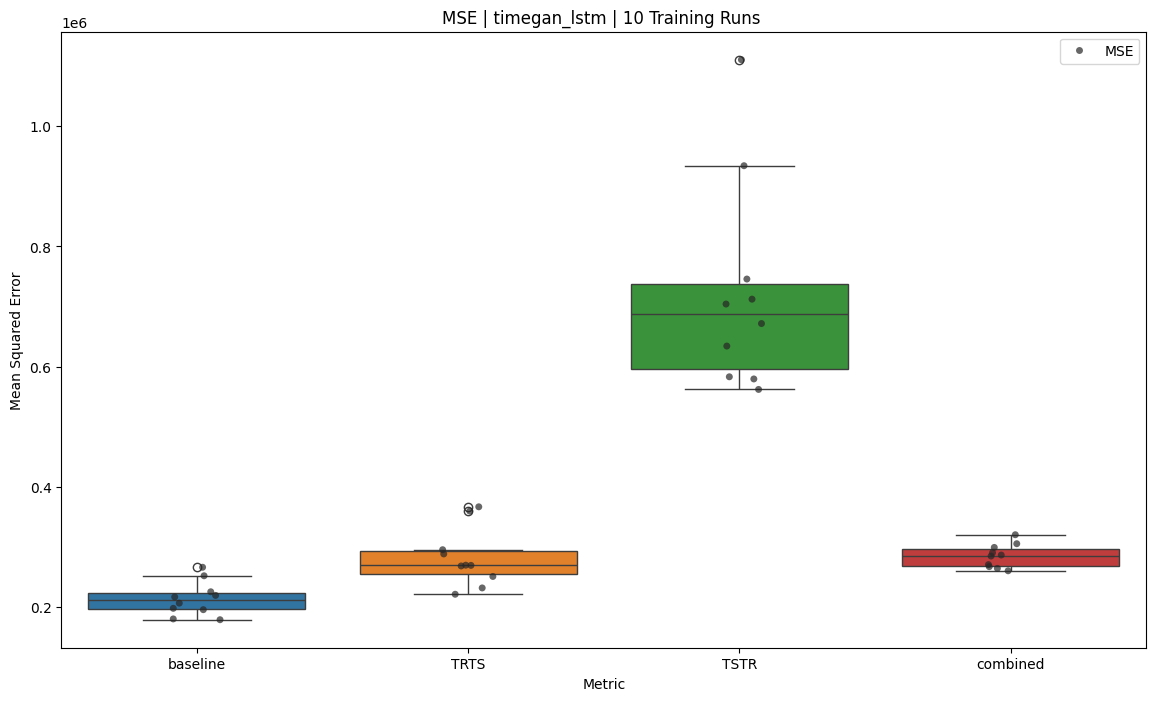

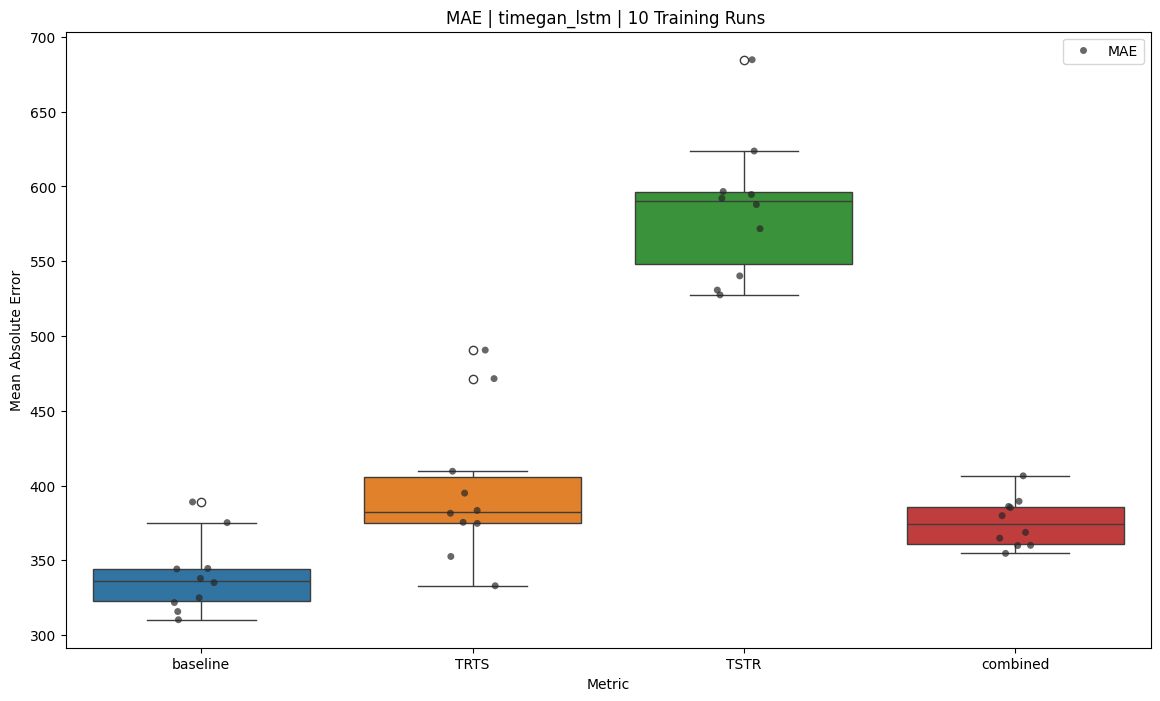

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [9]:
0.2*1e06

200000.0